# Hello Weather

Vibe-coded notebook for looking up weather info. Mostly done using Codex (meh).

In [1]:
import math
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Single City Weather

In [2]:
US_STATE_NAMES = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
}

def parse_location(name):
    parts = [p.strip() for p in name.split(',') if p.strip()]
    if not parts:
        raise ValueError('Location cannot be empty')
    city = parts[0]
    state = parts[1] if len(parts) > 1 else None
    country = parts[2] if len(parts) > 2 else None
    return city, state, country

def normalize_state(state):
    if not state:
        return None
    state = state.strip()
    if len(state) == 2:
        return US_STATE_NAMES.get(state.upper(), state)
    return state

def geocode_location(name):
    url = 'https://geocoding-api.open-meteo.com/v1/search'
    city, state, country = parse_location(name)
    state_name = normalize_state(state)
    params = {'name': city, 'count': 50}
    if country:
        params['country'] = country
    elif state_name:
        params['country'] = 'US'
    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    results = response.json().get('results', [])
    if state_name and results:
        state_match = state_name.lower()
        filtered = [r for r in results if (r.get('admin1') or '').lower() == state_match]
        results = filtered or results
    if not results:
        raise ValueError(f'No results for location: {name}')
    result = results[0]
    parts = [result.get('name'), result.get('admin1'), result.get('country_code')]
    location_name = ', '.join(p for p in parts if p)
    return {'name': location_name, 'latitude': result['latitude'], 'longitude': result['longitude']}

def wind_deg_to_cardinal(deg):
    if deg is None:
        return None
    directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    index = int((deg / 22.5) + 0.5) % 16
    return directions[index]

def fetch_current_weather(latitude, longitude):
    url = 'https://api.open-meteo.com/v1/forecast'
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'current': 'temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m',
        'temperature_unit': 'fahrenheit',
        'wind_speed_unit': 'mph',
    }
    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    return response.json().get('current', {})

def fetch_weather(location_name):
    location = geocode_location(location_name)
    current = fetch_current_weather(location['latitude'], location['longitude'])
    return location, current

In [3]:
def print_weather_stats(location_name):
    location, current = fetch_weather(location_name)
    pressure_hpa = current.get('pressure_msl')
    pressure_inhg = pressure_hpa * 0.029529983071445 if pressure_hpa is not None else None
    pressure_label = f'{pressure_inhg:.2f} inHg' if pressure_inhg is not None else 'N/A'
    wind_cardinal = wind_deg_to_cardinal(current.get('wind_direction_10m'))
    print(f'Location: {location["name"]}')
    print(f'Temperature: {current.get("temperature_2m")} °F')
    print(f'Humidity: {current.get("relative_humidity_2m")}%')
    print(f'Pressure: {pressure_label}')
    print(f'Wind: {current.get("wind_speed_10m")} mph {wind_cardinal}')

In [4]:
print_weather_stats('Palo Alto, CA')

Location: Palo Alto, California, US
Temperature: 39.8 °F
Humidity: 61%
Pressure: 30.30 inHg
Wind: 1.4 mph ENE


In [5]:
print_weather_stats('Liberty, SC')

Location: Liberty, South Carolina, US
Temperature: 28.9 °F
Humidity: 78%
Pressure: 30.38 inHg
Wind: 3.2 mph SSE


In [6]:
print_weather_stats('South Lake Tahoe, CA')

Location: South Lake Tahoe, California, US
Temperature: 19.8 °F
Humidity: 49%
Pressure: 30.27 inHg
Wind: 4.4 mph SSW


In [33]:
print_weather_stats('Reno, NV')

Location: Reno, Nevada, US
Temperature: 22.1 °F
Humidity: 69%
Pressure: 30.34 inHg
Wind: 3.6 mph W


## Temperature Map

In [7]:
def build_temperature_grid(center_lat, center_lon, span_deg=0.3, grid_size=7):
    lats = np.linspace(center_lat - span_deg, center_lat + span_deg, grid_size)
    lons = np.linspace(center_lon - span_deg, center_lon + span_deg, grid_size)
    lat_list = []
    lon_list = []
    for lat in lats:
        for lon in lons:
            lat_list.append(lat)
            lon_list.append(lon)
    url = 'https://api.open-meteo.com/v1/forecast'
    params = {
        'latitude': ','.join(f'{lat:.4f}' for lat in lat_list),
        'longitude': ','.join(f'{lon:.4f}' for lon in lon_list),
        'current': 'temperature_2m',
        'temperature_unit': 'fahrenheit',
    }
    response = requests.get(url, params=params, timeout=20)
    response.raise_for_status()
    data = response.json()
    if isinstance(data, dict):
        data = [data]
    temps = []
    for item in data:
        temp = item.get('current', {}).get('temperature_2m')
        temps.append(float(temp) if temp is not None else np.nan)
    temps_grid = np.array(temps, dtype=float).reshape(len(lats), len(lons))
    return lats, lons, temps_grid

def upsample_grid(lats, lons, temps, scale=6):
    new_lats = np.linspace(lats.min(), lats.max(), len(lats) * scale)
    new_lons = np.linspace(lons.min(), lons.max(), len(lons) * scale)
    temps_lon = np.array([np.interp(new_lons, lons, row) for row in temps])
    temps_dense = np.array([np.interp(new_lats, lats, temps_lon[:, j]) for j in range(temps_lon.shape[1])]).T
    return new_lats, new_lons, temps_dense

def deg_to_tile(lat, lon, zoom):
    lat_rad = np.radians(lat)
    n = 2 ** zoom
    xtile = (lon + 180.0) / 360.0 * n
    ytile = (1.0 - np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi) / 2.0 * n
    return xtile, ytile

def tile_to_deg(xtile, ytile, zoom):
    n = 2 ** zoom
    lon = xtile / n * 360.0 - 180.0
    lat_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
    lat = np.degrees(lat_rad)
    return lat, lon

def fetch_basemap(center_lat, center_lon, span_deg=0.3, zoom=7):
    min_lat = center_lat - span_deg
    max_lat = center_lat + span_deg
    min_lon = center_lon - span_deg
    max_lon = center_lon + span_deg
    x1, y1 = deg_to_tile(max_lat, min_lon, zoom)
    x2, y2 = deg_to_tile(min_lat, max_lon, zoom)
    x_min, x_max = int(math.floor(min(x1, x2))), int(math.floor(max(x1, x2)))
    y_min, y_max = int(math.floor(min(y1, y2))), int(math.floor(max(y1, y2)))
    tile_size = 256
    tiles = np.zeros(((y_max - y_min + 1) * tile_size, (x_max - x_min + 1) * tile_size, 3))
    headers = {'User-Agent': 'hello-weather'}
    for y in range(y_min, y_max + 1):
        for x in range(x_min, x_max + 1):
            url = f'https://tile.openstreetmap.org/{zoom}/{x}/{y}.png'
            response = requests.get(url, headers=headers, timeout=20)
            response.raise_for_status()
            img = mpimg.imread(BytesIO(response.content))[:, :, :3]
            y0 = (y - y_min) * tile_size
            x0 = (x - x_min) * tile_size
            tiles[y0:y0 + tile_size, x0:x0 + tile_size] = img
    lat_top, lon_left = tile_to_deg(x_min, y_min, zoom)
    lat_bottom, lon_right = tile_to_deg(x_max + 1, y_max + 1, zoom)
    extent = [lon_left, lon_right, lat_bottom, lat_top]
    return tiles, extent

In [26]:
def plot_temperature_map(location_name, span_deg=0.3, zoom=7):
    location, _ = fetch_weather(location_name)
    center_lat = float(location['latitude'])
    center_lon = float(location['longitude'])
    lats, lons, temps = build_temperature_grid(center_lat, center_lon, span_deg=span_deg)
    basemap, extent = fetch_basemap(center_lat, center_lon, span_deg=span_deg, zoom=zoom)
    dense_lats, dense_lons, dense_temps = upsample_grid(lats, lons, temps)
    fig, ax = plt.subplots(figsize=(6.5, 5.2))
    ax.set_facecolor('#f2f2f2')
    ax.imshow(basemap, extent=extent, origin='upper')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)
        spine.set_edgecolor('#1f1f1f')
    ax.imshow(dense_temps, extent=extent, origin='lower', cmap='turbo', alpha=0.6, interpolation='bilinear', vmin=10, vmax=80)
    cbar = fig.colorbar(ax.images[-1], ax=ax, fraction=0.04, pad=0.02)
    cbar.set_label('Air Temperature (°F)', fontsize=10, labelpad=8)
    cbar.ax.tick_params(labelsize=9)
    ax.scatter([center_lon], [center_lat], c='white', s=30, edgecolors='black')
    ax.set_title(f'{location["name"]}', fontsize=12, fontweight='semibold', pad=10)
    ax.set_xlim(extent[0], extent[1])
    ax.set_axis_off()
    ax.set_ylim(extent[2], extent[3])
    plt.show()

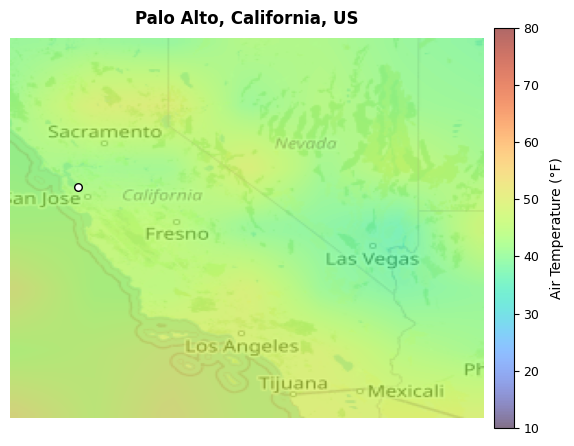

In [27]:
location_name = 'Palo Alto, CA'
plot_temperature_map(location_name, zoom=5)

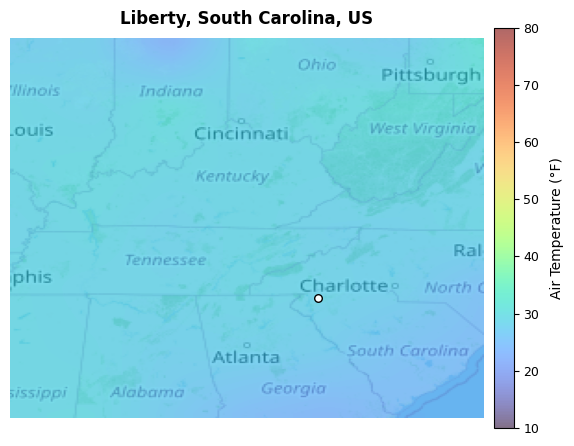

In [28]:
location_name = 'Liberty, SC'
plot_temperature_map(location_name, zoom=5)

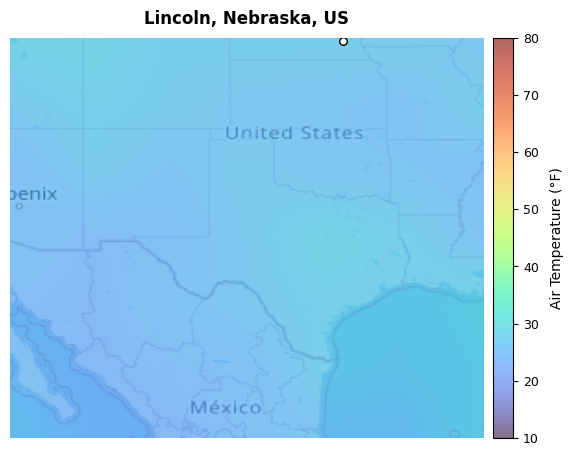

In [31]:
location_name = 'Lincoln, NE'
plot_temperature_map(location_name, zoom=4, span_deg=0.1)

In [ ]:
# notes
# the temperature grid looks incorrect, showing a lot of places colder/warmer than they should be
# the scaling and plot sizing are still janky
# the plots poorly center around location
# why stick with such clunky code? isn't there an easier library for this stuff?